## Challenge 1

I have choosing challenge 1, because it seems like the more fun dataset to test and play around.
* First I load all necessary packages and helper functions
* Second loading the data and clean it if necessary
* Third exploring the data and look for patterns
* Fourth model the data in order to create a anaomaly detection system, which igores gapes in the data

In [1]:
# loading all packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [2]:
# defining all necessary helper functions
## define functions for missings
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

# color the cells based on their value for the describe function
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [3]:
# load the data
df = pd.read_csv('sample_temperature_data_for_coding_challenge.csv')

In [4]:
# show the data
df.head(3)

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13T17:51:16.000+0000,heating_temperature,33.3
1,MICDEV001,2019-04-13T17:51:16.000+0000,cooling_temperature,15.0
2,MICDEV001,2019-04-13T18:51:18.000+0000,heating_temperature,34.0


In [5]:
# take a look at the shape
df.shape

(1000, 4)

In [6]:
# check for occurence of property names
df.property_name.value_counts()

property_name
heating_temperature    699
cooling_temperature    301
Name: count, dtype: int64

In [7]:
# describe the data set
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
temperature,1000.000000,29.529700,7.132047,14.900000,24.775000,32.900000,34.500000,39.400000


In [8]:
# check for types
df.dtypes

source_id         object
datetime          object
property_name     object
temperature      float64
dtype: object

In [9]:
# check for missings
missing_values_table(df)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [10]:
# check for possible categorical columns
plt.style.use('fivethirtyeight')
catanadf = analyse_cats(df, df.columns)
catanadf

,"""feat""",uniques,cardinality,nans
0,source_id,[MICDEV001],1,0
1,datetime,"[2019-04-13T17:51:16.000+0000, 2019-04-13T18:5...",716,0
2,property_name,"[heating_temperature, cooling_temperature]",2,0
3,temperature,"[33.3, 15.0, 34.0, 33.8, 34.2, 34.5, 34.7, 34....",172,0


In [11]:
# how many different devices are there?
df.source_id.value_counts()

source_id
MICDEV001    1000
Name: count, dtype: int64

In [12]:
# create time series
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

# Show new data set
df.head(3)

,source_id,datetime,property_name,temperature,date,month,weekday,hour
0,MICDEV001,2019-04-13 17:51:16+00:00,heating_temperature,33.3,2019-04-13,4,5,17
1,MICDEV001,2019-04-13 17:51:16+00:00,cooling_temperature,15.0,2019-04-13,4,5,17
2,MICDEV001,2019-04-13 18:51:18+00:00,heating_temperature,34.0,2019-04-13,4,5,18


In [13]:
# Group by source_id and date and count the number of readings per group
readings_per_day_per_property = df.groupby(['source_id', 'date','property_name']).size().reset_index(name='readings_count')

# Display the first few rows of the result
readings_per_day_per_property.head(15)

,source_id,date,property_name,readings_count
0,MICDEV001,2019-04-13,cooling_temperature,1
1,MICDEV001,2019-04-13,heating_temperature,7
2,MICDEV001,2019-04-14,cooling_temperature,11
3,MICDEV001,2019-04-14,heating_temperature,19
4,MICDEV001,2019-04-15,cooling_temperature,4
5,MICDEV001,2019-04-15,heating_temperature,20
6,MICDEV001,2019-04-16,cooling_temperature,2
7,MICDEV001,2019-04-16,heating_temperature,12
8,MICDEV001,2019-04-17,cooling_temperature,4
9,MICDEV001,2019-04-17,heating_temperature,5


In [14]:
# Check if there are days without heating temps, when cooling temps are present
heating_data = df[df['property_name'] == 'heating_temperature'].groupby('date').max()
cooling_data = df[df['property_name'] == 'cooling_temperature'].groupby('date').max()
days_with_cooling_only = cooling_data.index.difference(heating_data.index)
days_with_cooling_only

Index([], dtype='object', name='date')

In [15]:
# ignore warnings
warnings.filterwarnings("ignore")

# create cooling and heating dataset
df_heating = df[df['property_name'] == 'heating_temperature']
df_cooling = df[df['property_name'] == 'cooling_temperature']
df_heating['datetime'] = pd.to_datetime(df_heating['datetime'])
df_cooling['datetime'] = pd.to_datetime(df_cooling['datetime'])

# Create a set of tuples
heating_dates = set(zip(df_heating['source_id'], df_heating['datetime']))

# Count how many cooling temperatures dont match
non_matching_cooling_temps = sum((row['source_id'], row['datetime']) not in heating_dates for index, row in df_cooling.iterrows())

non_matching_cooling_temps

17

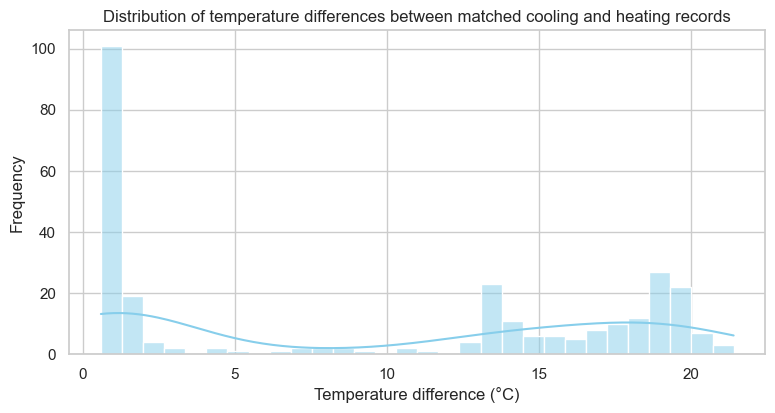

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

matched_temps = pd.merge(df_cooling, df_heating, on=['source_id', 'datetime'], suffixes=('_cooling', '_heating'))

# Calculate the temperature difference between each matched cooling and heating temperature
matched_temps['temp_difference'] = matched_temps['temperature_heating'] - matched_temps['temperature_cooling']
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a distribution plot for the temperature differences
plt.figure(figsize=(8, 4))
sns.histplot(matched_temps['temp_difference'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of temperature differences between matched cooling and heating records')
plt.xlabel('Temperature difference (°C)')
plt.ylabel('Frequency')

plt.show()

In [17]:
# temp difference for each hour
matched_temps.groupby("hour_heating").temp_difference.describe()

,count,mean,std,min,25%,50%,75%,max
hour_heating,,,,,,,,
7,2.0,0.900000,2.512148e-15,0.9,0.900,0.90,0.900,0.9
8,15.0,2.866667,4.371117e+00,0.8,1.050,1.10,1.400,13.7
9,38.0,5.702632,6.545000e+00,0.7,1.000,1.15,13.275,19.8
10,38.0,11.460526,7.110196e+00,0.8,1.400,14.10,16.250,20.6
11,27.0,8.607407,7.370415e+00,0.8,1.100,8.50,15.550,19.7
12,23.0,11.017391,8.151779e+00,0.6,1.150,15.20,18.100,19.6
13,20.0,10.135000,8.306831e+00,0.7,1.400,10.45,18.800,21.0
14,26.0,8.653846,8.363312e+00,0.7,1.000,2.10,17.450,19.5
15,29.0,11.134483,8.471603e+00,0.8,1.100,15.70,19.200,20.2


## First Impressions

* There are 1000 entries for one devices over several month with several readings per day.
* The readings for each property name are not constant and different for both groups, there are also several gaps between days.
* Most of the cooling readings have heating reading in the same hour, only 17 do not match, therefore for anomaly modeling we could generate 17 more heating events with those cooling events and add the mean difference of the specific hour.
* The next steps will be to look up the distribution of temperature readings aswell as variances of month, week, hour as well as the auto correlation of heating and cooling. I will test for homoscedacity aswell as stationarity of the time series in order to create a reliable model 

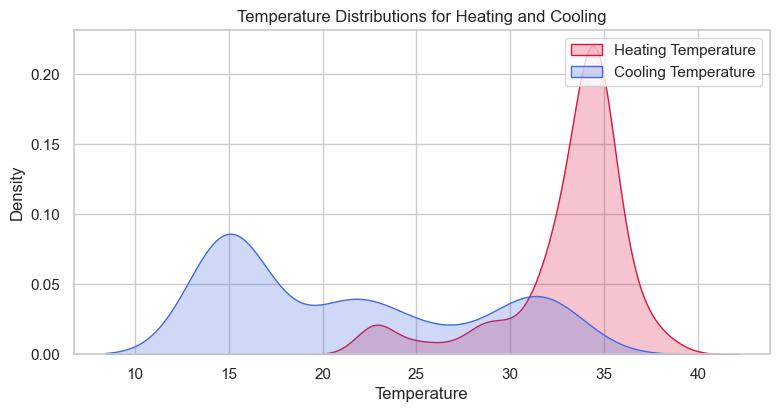

In [18]:
# Plot densities of both types of temperature properties
heating_df = df[df['property_name'] == 'heating_temperature']['temperature']
cooling_df = df[df['property_name'] == 'cooling_temperature']['temperature']

plt.figure(figsize=(8, 4))  

# create density plot
sns.kdeplot(heating_df, label='Heating Temperature', fill=True,color='crimson')  
sns.kdeplot(cooling_df, label='Cooling Temperature', fill=True,color='royalblue')  

plt.title('Temperature Distributions for Heating and Cooling')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

## Temperature anomalies

* We can observe anomilies for the heating temperature, if we account for the fact that most observation are between 30 and 35 degrees.
* While observations for cooling are all over the place

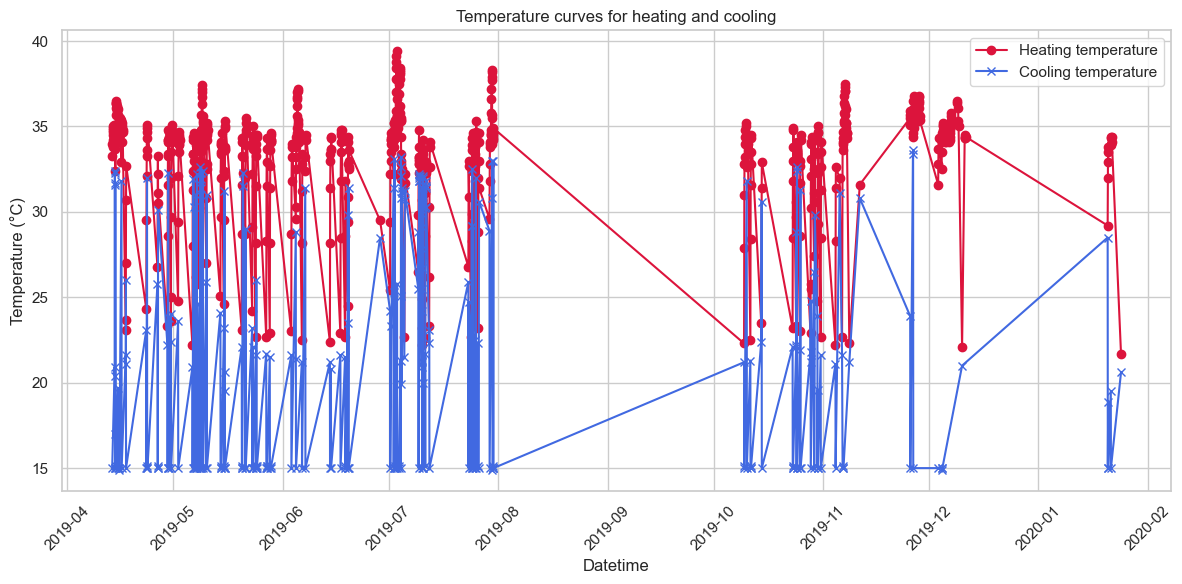

In [19]:
# Filtering and averaging temperatures
heating_temps = df[df['property_name'] == 'heating_temperature'].groupby('datetime')['temperature'].mean()
cooling_temps = df[df['property_name'] == 'cooling_temperature'].groupby('datetime')['temperature'].mean()

# PLot timeseries
plt.figure(figsize=(12, 6))
plt.plot(heating_temps.index, heating_temps, label='Heating temperature', marker='o',color='crimson')
plt.plot(cooling_temps.index, cooling_temps, label='Cooling temperature', marker='x',color='royalblue')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature curves for heating and cooling')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

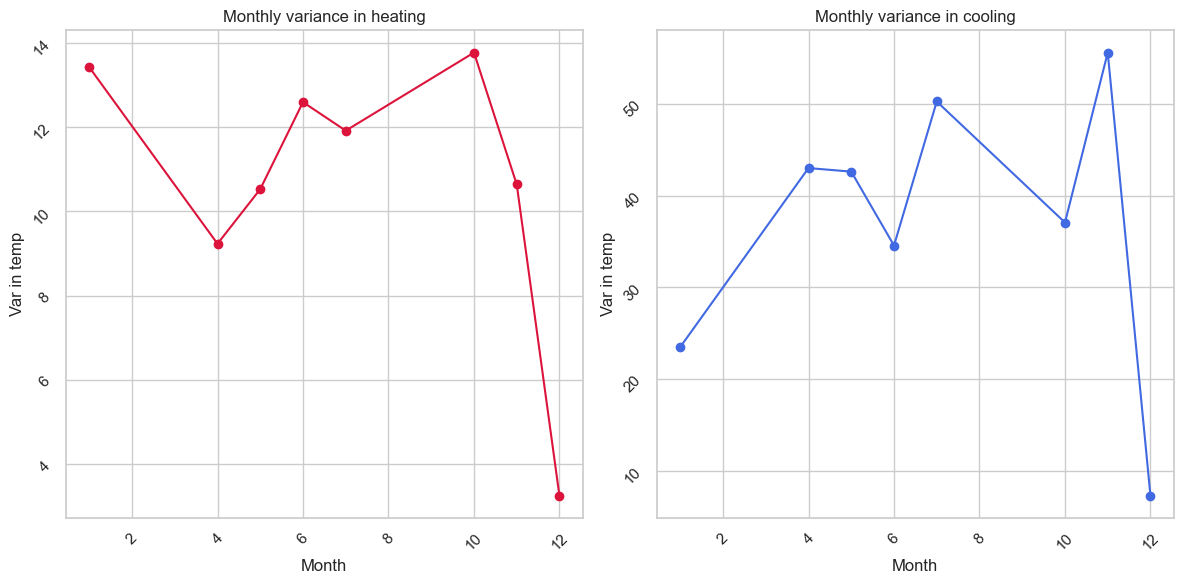

In [20]:
### variance plot for month
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance hour
monthly_temp_variance_heat = heating_data.groupby('month')['temperature'].var().reset_index()
monthly_temp_variance_cool = cooling_data.groupby('month')['temperature'].var().reset_index()

# create esubplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# heating plot
axs[0].plot(monthly_temp_variance_heat['month'], monthly_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Monthly variance in heating')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

# cooling plot
axs[1].plot(monthly_temp_variance_cool['month'], monthly_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Monthly variance in cooling')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

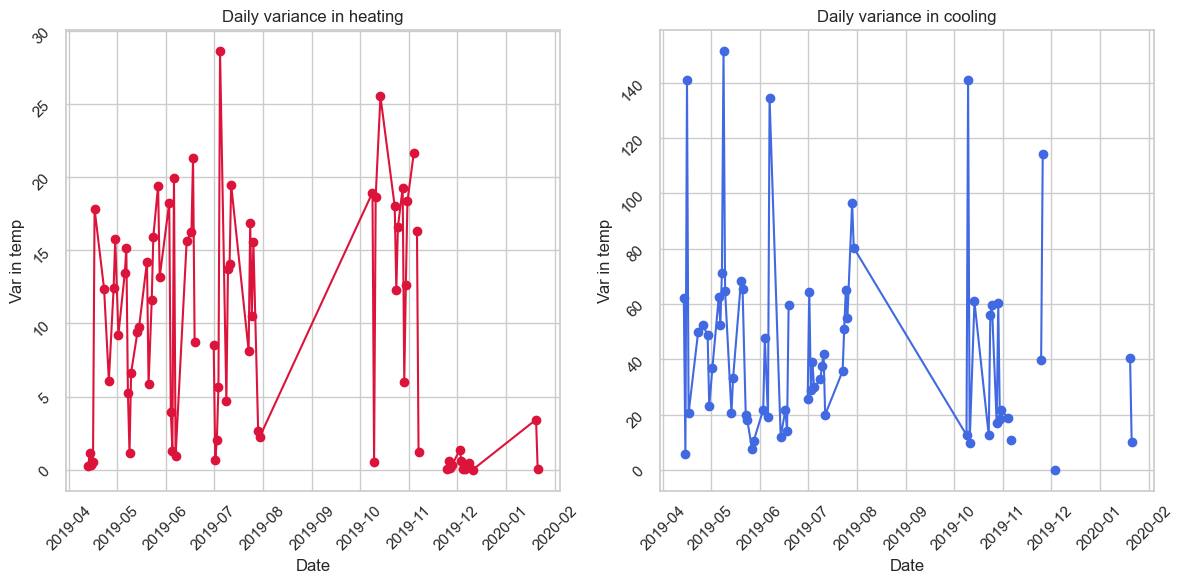

In [21]:
### variance plot for days
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance day
daily_temp_variance_heat = heating_data.groupby('date')['temperature'].var().reset_index()
daily_temp_variance_cool = cooling_data.groupby('date')['temperature'].var().reset_index()

# get variance hour
hourly_temp_variance_heat = heating_data.groupby('hour')['temperature'].var().reset_index()
hourly_temp_variance_cool = cooling_data.groupby('hour')['temperature'].var().reset_index()

# create subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# variance plots
axs[0].plot(daily_temp_variance_heat['date'], daily_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Daily variance in heating')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

axs[1].plot(daily_temp_variance_cool['date'], daily_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Daily variance in cooling')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

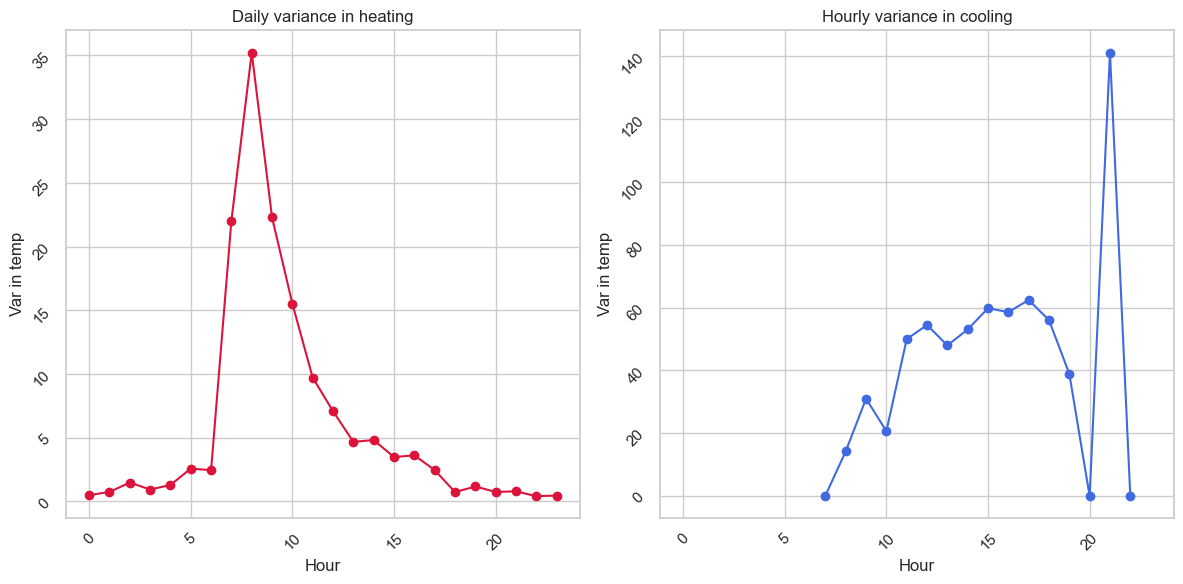

In [22]:
### variance plot for hours
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance hour
hourly_temp_variance_heat = heating_data.groupby('hour')['temperature'].var().reset_index()
hourly_temp_variance_cool = cooling_data.groupby('hour')['temperature'].var().reset_index()

# create esubplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# heating plot
axs[0].plot(hourly_temp_variance_heat['hour'], hourly_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Daily variance in heating')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

# cooling plot
axs[1].plot(hourly_temp_variance_cool['hour'], hourly_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Hourly variance in cooling')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

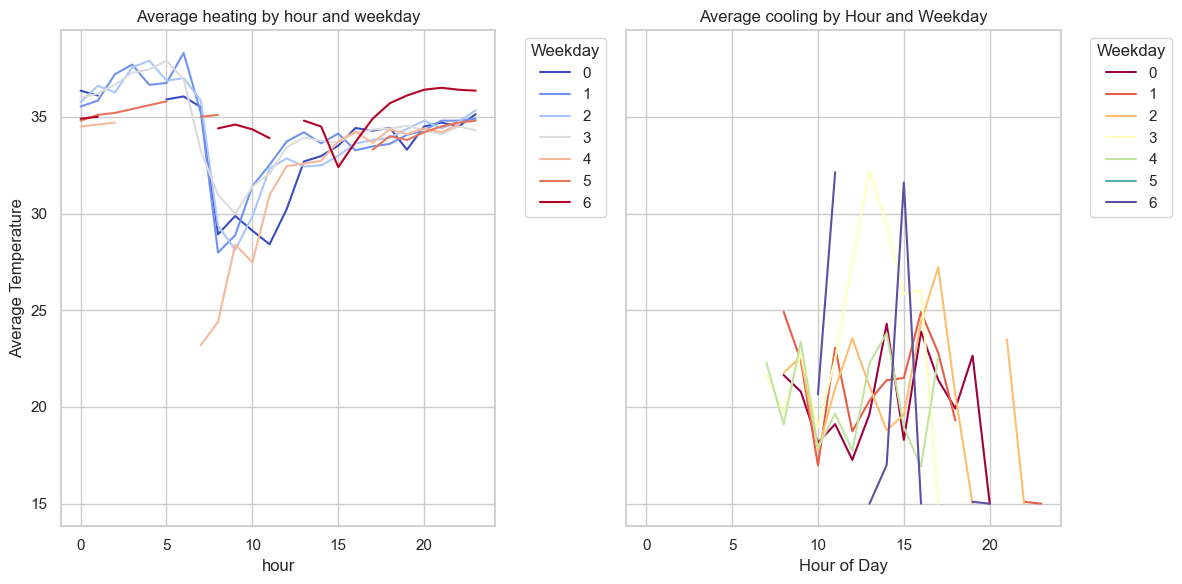

In [23]:
# Grouping for plots
heating_temp_by_hour_weekday = df[df['property_name'] == 'heating_temperature'].groupby(['hour', 'weekday'])['temperature'].mean().unstack()
cooling_temp_by_hour_weekday = df[df['property_name'] == 'cooling_temperature'].groupby(['hour', 'weekday'])['temperature'].mean().unstack()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot temperature
heating_temp_by_hour_weekday.plot(ax=axs[0], colormap='coolwarm', title='Average heating by hour and weekday')
cooling_temp_by_hour_weekday.plot(ax=axs[1], colormap='Spectral', title='Average cooling by Hour and Weekday')

# Setting labels
axs[0].set_ylabel('Average Temperature')
axs[1].set_ylabel('Average Temperature')
axs[1].set_xlabel('Hour of Day')

# Legends and layout
axs[0].legend(title='Weekday', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].legend(title='Weekday', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Stable time series

* As we can see the time series for heating is rather stable, while for cooling its really all over the place
* Therefore for modeling I will use the differences of cooling, when there is cooling present

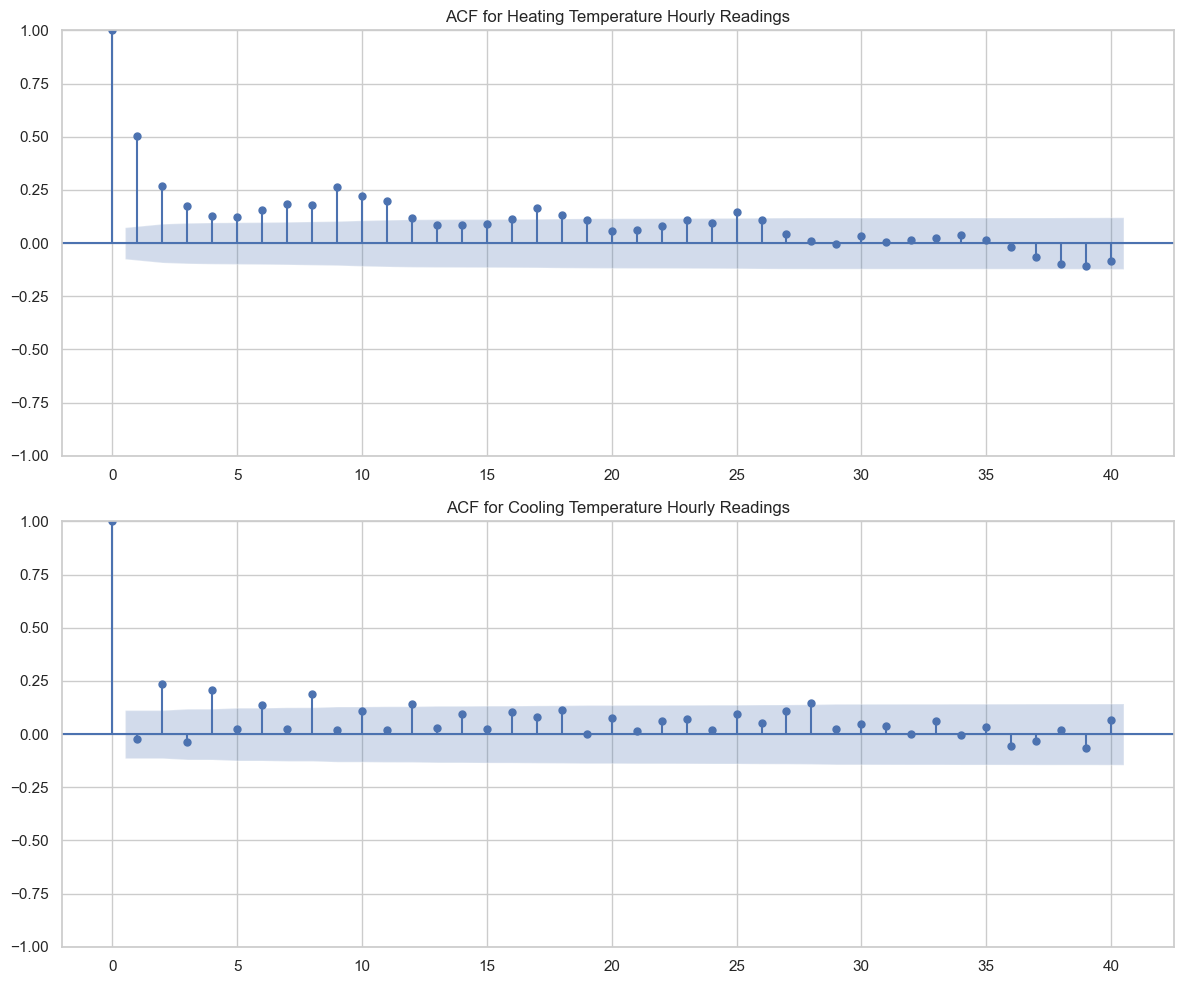

In [24]:
# For this analysis, we need to ensure our data is ordered by datetime and then by hour for each temperature type
heating_data_hourly = df[df['property_name'] == 'heating_temperature'].sort_values(by='datetime')
cooling_data_hourly = df[df['property_name'] == 'cooling_temperature'].sort_values(by='datetime')

# drop nas
heating_data_hourly = heating_data_hourly.dropna(subset=['temperature'])
cooling_data_hourly = cooling_data_hourly.dropna(subset=['temperature'])

# Setting up the figure for ACF plots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot for Heating Temperature
plot_acf(heating_data_hourly['temperature'], ax=axs[0], lags=40, title='ACF for Heating Temperature Hourly Readings')

# ACF plot for Cooling Temperature
plot_acf(cooling_data_hourly['temperature'], ax=axs[1], lags=40, title='ACF for Cooling Temperature Hourly Readings')

plt.tight_layout()
plt.show()

In [25]:
# Assigning a numerical value to each unique month
unique_month = monthly_temp_variance_heat['month'].unique()
month_to_numeric = {month: i for i, month in enumerate(unique_month)}
heating_data['month_numeric'] = heating_data['month'].map(month_to_numeric)

X_days = add_constant(heating_data['month_numeric'])
Y_temp = heating_data['temperature']
model_month = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test 
bp_test_month = het_breuschpagan(model_month.resid, model_month.model.exog)

# Assigning a numerical value to each unique day
unique_days = daily_temp_variance_heat['date'].unique()
day_to_numeric = {day: i for i, day in enumerate(unique_days)}
heating_data['date_numeric'] = heating_data['date'].map(day_to_numeric)

# Preparing independent (X) and dependent (Y) variables
X_days = add_constant(heating_data['date_numeric'])
Y_temp = heating_data['temperature']

# Fit regression model for days vs temperature
model_days = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test for days vs temperature
bp_test_days = het_breuschpagan(model_days.resid, model_days.model.exog)

# Assigning a numerical value to each unique hour
unique_hours = hourly_temp_variance_heat['hour'].unique()
hour_to_numeric = {hour: i for i, hour in enumerate(unique_hours)}
heating_data['hour_numeric'] = heating_data['hour'].map(hour_to_numeric)

X_days = add_constant(heating_data['hour_numeric'])
Y_temp = heating_data['temperature']

# Fit regression model for days vs temperature
model_hours = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test 
bp_test_hours = het_breuschpagan(model_hours.resid, model_hours.model.exog)

print(f'''Different p values for the Breusch Pagan test, to evaluate heteroscedacity in heating data: \n
P-Value for monthly series: {bp_test_month[1]}\n
P-Value for daily series: {bp_test_days[1]}\n
P-Value for daily series: {bp_test_hours[1]}''')

Different p values for the Breusch Pagan test, to evaluate heteroscedacity in heating data: 

P-Value for monthly series: 0.7835009476786754

P-Value for daily series: 0.7773445880103482

P-Value for daily series: 3.745826415732416e-14


In [26]:
# Dickey-Fuller test
adf_test = adfuller(heating_data['temperature'])

# Results
adf_output = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4],
}
print('Test Statistic for dickey fuller test for heating data:')
adf_output

Test Statistic for dickey fuller test for heating data:


{'Test Statistic': -5.059911358853022,
 'p-value': 1.68684343983509e-05,
 'Lags Used': 8,
 'Number of Observations Used': 690,
 'Critical Values': {'1%': -3.4398627454742488,
  '5%': -2.8657378555534248,
  '10%': -2.569005465238395}}

## Brief summary of exploration

* Month and week data show no heteroscedacity. Hours show it, but thats to be expected and the trend for most of the heating seems to be stable, cooling shows very strange patterns and will only be used as a proxy for modeling heating.
* The series itself is stationary and therefore controlling for autocorrelation and the 24 hour cycle of heating should be enough to catch outliers.
* Also taking the temp difference to cooling, if cooling is present might of further insights, aswell temp difference to previous data points.
* I will first built a baseline model only catching 5% and 95% percentile for 3 month at the beginning of the timeseries, where i have enough data and then apply it to the rest to see, how well it performs.
* Then I will use an isolated random forest model and a svm with features like lags, time difference if cooling is there aswell as hours and the current temp.
* I skip the whole 3rd quarter of 2019 as test or train data where there is no data point at all for simplicity.
* I also drop the idea to fill out the heating data in the simple naive model, but will do it for the more complex model

In [27]:
# Lets define train and test sets
# Training set is going to be from april 2019 to june 2019
# Test set 1 is going to be july to august and october to january

# Define heating data again
heating_data = df[df['property_name'] == 'heating_temperature']
heating_data.set_index('datetime', inplace=True)
# Slice the data according to the given periods
training_data = heating_data['2019-04-01':'2019-06-30']
first_test_data = heating_data['2019-07-01':'2019-08-31']
second_test_data = heating_data['2019-10-01':'2020-01-31'] 

In [28]:
# create static quantiles in the training data
percentiles = training_data.groupby('hour')['temperature'].quantile([0.05, 0.95]).unstack().reset_index()
percentiles.columns = ['hours','5th_Percentile', '95th_Percentile']

In [29]:
# create function to mark extreme values
def mark_extreme_values(row, quantiles):
    hour = row.name.hour
    temp = row['temperature']
    if temp < percentiles.loc[hour, '5th_Percentile']:
        return 'Below 5th_Percentile'
    elif temp > percentiles.loc[hour, '95th_Percentile']:
        return 'Above 95th_Percentile'
    else:
        return 'Within Range'

# Apply the function to the first test set
first_test_data['anomaly'] = first_test_data.apply(lambda row: mark_extreme_values(row, percentiles.columns), axis=1)

# Apply the function to the second test set similarly
second_test_data['anomaly'] = second_test_data.apply(lambda row: mark_extreme_values(row, percentiles.columns), axis=1)

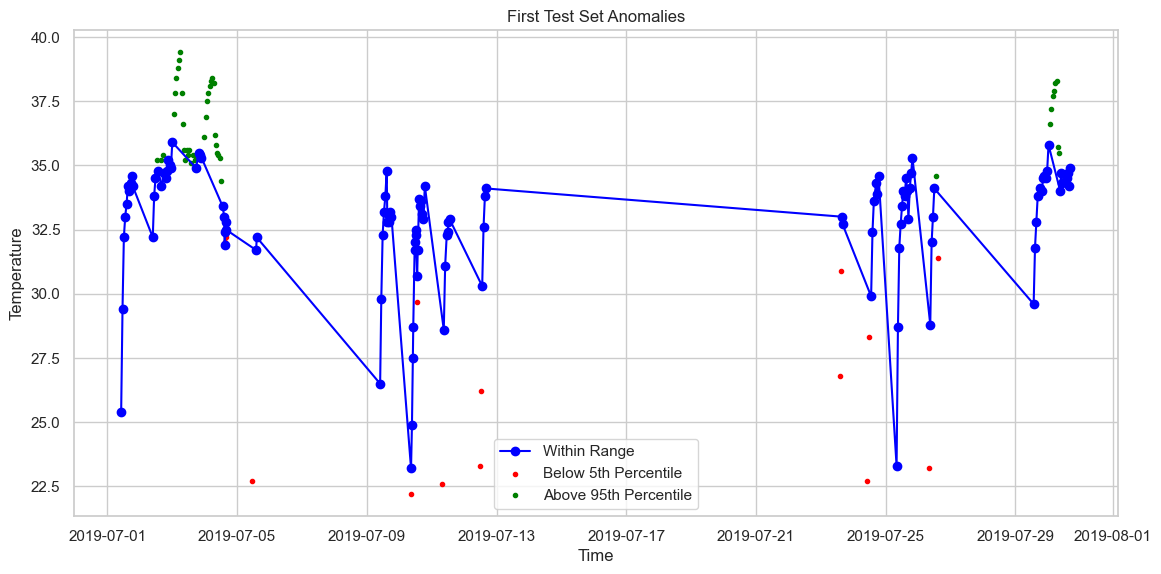

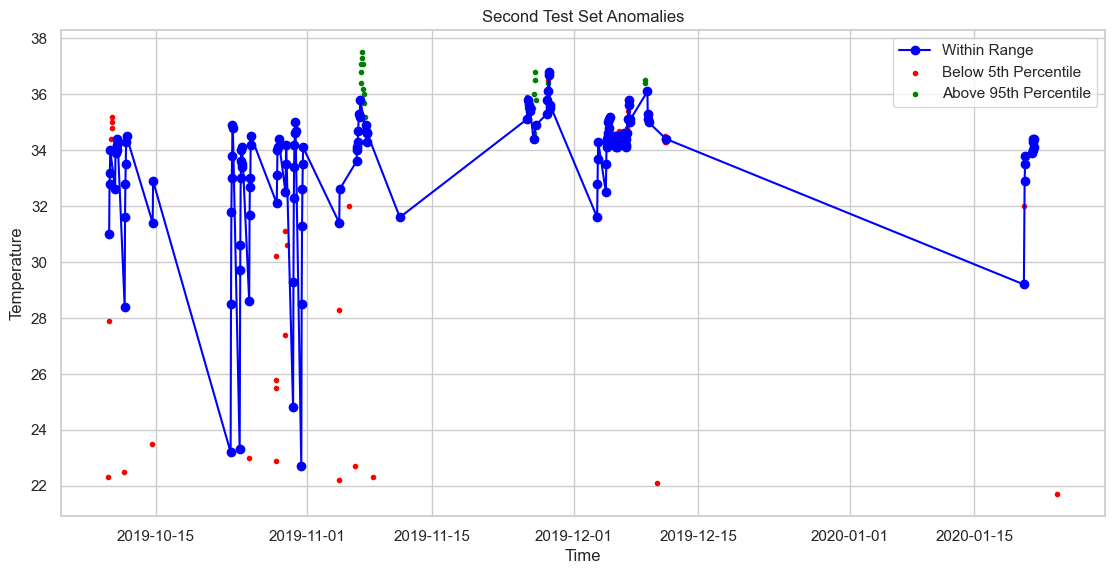

In [30]:
# Create anaomily plits
def plot_with_anomalies(test_data, title):

    normal_data = test_data[test_data['anomaly'] == 'Within Range']

    below_5 = test_data[test_data['anomaly'] == 'Below 5th_Percentile']
    above_95 = test_data[test_data['anomaly'] == 'Above 95th_Percentile']

    plt.figure(figsize=(12, 6))
    plt.plot(normal_data.index, normal_data['temperature'], label='Within Range', color='blue', marker='o', linestyle='-')
    plt.scatter(below_5.index, below_5['temperature'], color='red', label='Below 5th Percentile', marker='.')
    plt.scatter(above_95.index, above_95['temperature'], color='green', label='Above 95th Percentile', marker='.')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Plot first test set
plot_with_anomalies(first_test_data, 'First Test Set Anomalies')

# Plot second test set
plot_with_anomalies(second_test_data, 'Second Test Set Anomalies')

##### Baseline model summary

* The baseline model already captures some anomalies, but is very rough and might produce too many false positive in a real life scenario
* Also it lacks the cooling data difference, which might be important if cooling data behaves strange as well
* However its easy to implement and a good starting point.

## New features

In [31]:
## Built features for isolated random forest
# We already have the features weekday and hour and ofc temperature
# Now I create lag features for the last entry as well as diff to cooling if there is a difference
# Convert the 'datetime' column to datetime type
# reaload data
df = pd.read_csv('sample_temperature_data_for_coding_challenge.csv')
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Separate heating and cooling temperatures
heating = df[df['property_name'] == 'heating_temperature'].rename(columns={'temperature': 'heating_temperature'})
cooling = df[df['property_name'] == 'cooling_temperature'].rename(columns={'temperature': 'cooling_temperature'})

# Combine the two datasets
combined=pd.concat([heating,cooling],axis=1)

# calcualte differene of temp in combined data set
combined['temp_difference'] = abs(combined.heating_temperature - combined.cooling_temperature)
combined['lag1_heating'] = combined['heating_temperature'].shift(1)

In [32]:
# Slice the data according to the given periods
train = combined['2019-04-01':'2019-06-30']
first_test = combined['2019-07-01':'2019-08-31']
second_test = combined['2019-10-01':'2020-01-31'] 

In [33]:
# get mean temp diff for imputation of data in training and both test sets
train_diff_mean = train['temp_difference'].mean()
train_diff_25 = train['temp_difference'].quantile(0.25)
train_diff_75 = train['temp_difference'].quantile(0.75)

In [34]:
# fill gaps for all sets with training params
train['heating_temperature'] = np.where(train['heating_temperature'].isnull(),(train['cooling_temperature']+train_diff_mean),train['heating_temperature'])
first_test['heating_temperature'] = np.where(first_test['heating_temperature'].isnull(),(first_test['cooling_temperature']+train_diff_mean),first_test['heating_temperature'])
second_test['heating_temperature']= np.where(second_test['heating_temperature'].isnull(),(second_test['cooling_temperature']+train_diff_mean),second_test['heating_temperature'])

In [35]:
# bin difference in order to have meaningful feature, there will be neutral, low difference and high difference by quantiles
train['binned_diff'] = np.where(train['temp_difference'].isnull(),'no_diff',
                       np.where(train['temp_difference']<train_diff_25,'low_diff',
                       np.where(train['temp_difference']>train_diff_75,'high_diff','neural_diff')))

first_test['binned_diff'] = np.where(first_test['temp_difference'].isnull(),'no_diff',
                       np.where(first_test['temp_difference']<train_diff_25,'low_diff',
                       np.where(first_test['temp_difference']>train_diff_75,'high_diff','neural_diff')))


second_test['binned_diff'] = np.where(second_test['temp_difference'].isnull(),'no_diff',
                       np.where(second_test['temp_difference']<train_diff_25,'low_diff',
                       np.where(second_test['temp_difference']>train_diff_75,'high_diff','neural_diff')))

In [36]:
# reset indices and drop some variables
train= train.reset_index()
first_test = first_test.reset_index()
second_test = second_test.reset_index()

In [37]:
# extract week day and hours
train['weekday'] = train['datetime'].dt.weekday
train['hour'] = train['datetime'].dt.hour

first_test['weekday'] = first_test['datetime'].dt.weekday
first_test['hour'] = first_test['datetime'].dt.hour

second_test['weekday'] = second_test['datetime'].dt.weekday
second_test['hour'] = second_test['datetime'].dt.hour

In [38]:
# get weekend
train['weekend']=np.where(train['weekday'].isin([5,6]),'weekend','workday')
first_test['weekend']=np.where(first_test['weekday'].isin([5,6]),'weekend','workday')
second_test['weekend']=np.where(second_test['weekday'].isin([5,6]),'weekend','workday')

In [39]:
# Clean datasets
train = train.drop(columns=['property_name','source_id','cooling_temperature','temp_difference','weekday'])
first_test = first_test.drop(columns=['property_name','source_id','cooling_temperature','temp_difference','weekday'])
second_test = second_test.drop(columns=['property_name','source_id','cooling_temperature','temp_difference','weekday'])

In [40]:
# give hours category type to dummyfy them
train = train.astype({'hour':'category'})
first_test = first_test.astype({'hour':'category'})
second_test = second_test.astype({'hour':'category'})

In [41]:
train = pd.get_dummies(train, dtype=float)
first_test = pd.get_dummies(first_test , dtype=float)
second_test = pd.get_dummies(second_test, dtype=float)

In [42]:
# get time for later
train_datetime=train[['datetime','heating_temperature']]
first_test_datetime=first_test[['datetime','heating_temperature']]
second_test_datetime=second_test[['datetime','heating_temperature']]

# drop time
train = train.drop(columns=['datetime'])
first_test = first_test.drop(columns=['datetime'])
second_test = second_test.drop(columns=['datetime'])

# add weekend for first_test
first_test['weekend_weekend'] = 0

In [43]:
def preprocess_data(X_train: pd.DataFrame) -> tuple:
    """
    Preprocess the data by imputing missing values using KNN for numerical features,
    and scaling numerical features.
    
    Args:
        X_train (pd.DataFrame): The training data.
        X_test (pd.DataFrame): The test data.
        
    Returns:
        tuple: The preprocessed training data, test data, and the preprocessing pipeline.
    """
    # Identifying numerical features
    num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Pipeline for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=3)),  
        ('scaler', StandardScaler()) 
    ])
    
    # Preprocessor with only numerical transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_features)
        ],
        remainder='passthrough'  # Pass through categorical features unchanged
    )

    # Fitting and transforming the training data
    X_train_prep = preprocessor.fit_transform(X_train)
    
    return X_train_prep, preprocessor


train,preprocessor = preprocess_data(train)
first_test = preprocessor.transform(first_test)
second_test =preprocessor.transform(second_test)

In [44]:
outlier_fraction=0.1

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples='auto', 
                                       contamination=outlier_fraction,random_state=5, verbose=0),
    
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=5, gamma=0.05,nu=0.05, 
                                         max_iter=-1)
}

In [45]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Support Vector Machine":
        svm = clf.fit(train)
    else:    
        forest= clf.fit(train)

In [46]:
# create test prediction dataframes
first_test_datetime['forest_pred']= forest.predict(first_test)
second_test_datetime['forest_pred']= forest.predict(second_test)

first_test_datetime['svm_pred']= svm.predict(first_test)
second_test_datetime['svm_pred']= svm.predict(second_test)

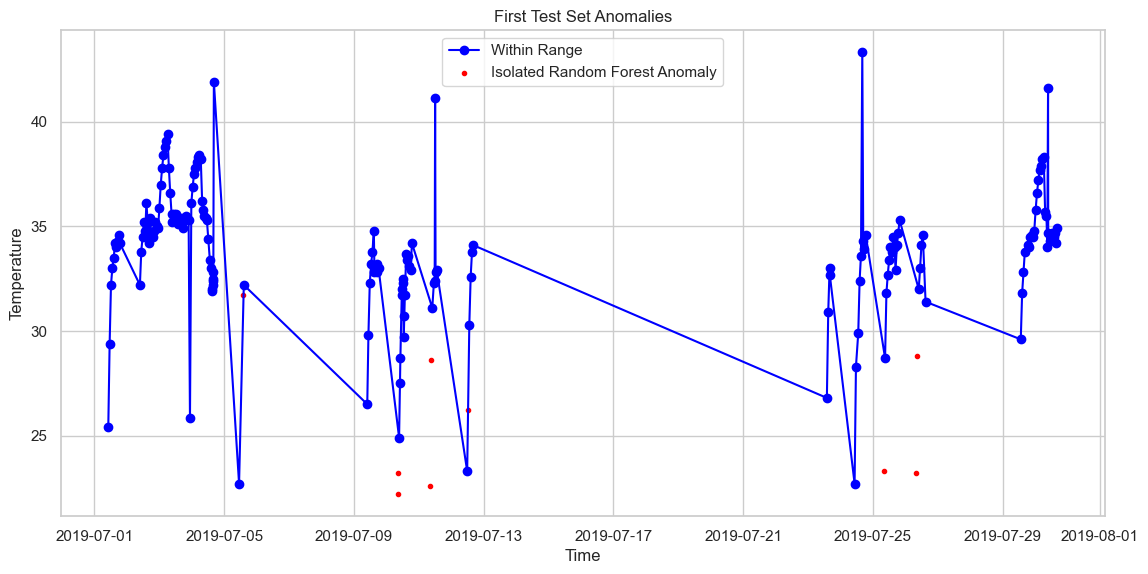

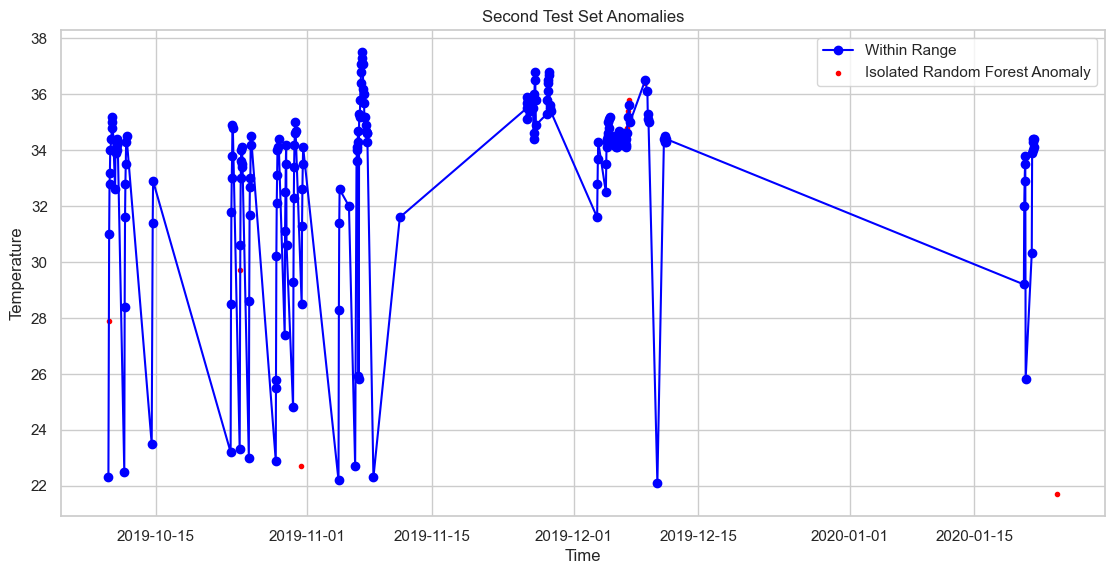

In [47]:
# Create anaomily plits
def plot_with_anomalies(test_data, title):

    normal_data = test_data[test_data['forest_pred'] == 1]

    forest = test_data[test_data['forest_pred'] == -1]

    plt.figure(figsize=(12, 6))
    plt.plot(normal_data.index, normal_data['heating_temperature'], label='Within Range', color='blue', marker='o', linestyle='-')
    plt.scatter(forest.index, forest['heating_temperature'], color='red', label='Isolated Random Forest Anomaly', marker='.')

    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Plot first test set
plot_with_anomalies(first_test_datetime.set_index('datetime'), 'First Test Set Anomalies')

# Plot second test set
plot_with_anomalies(second_test_datetime.set_index('datetime'), 'Second Test Set Anomalies')

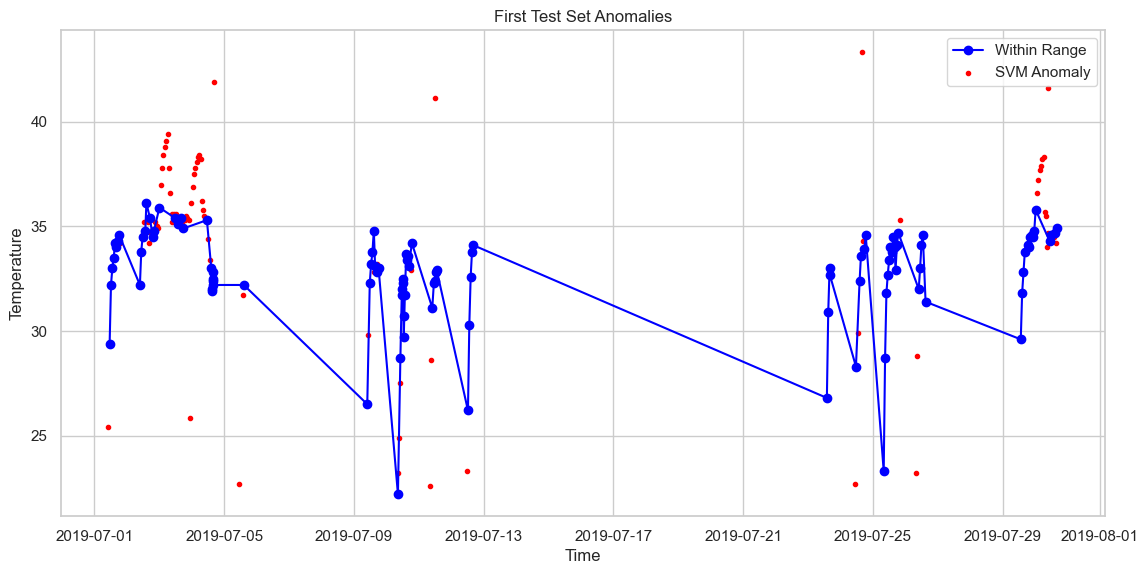

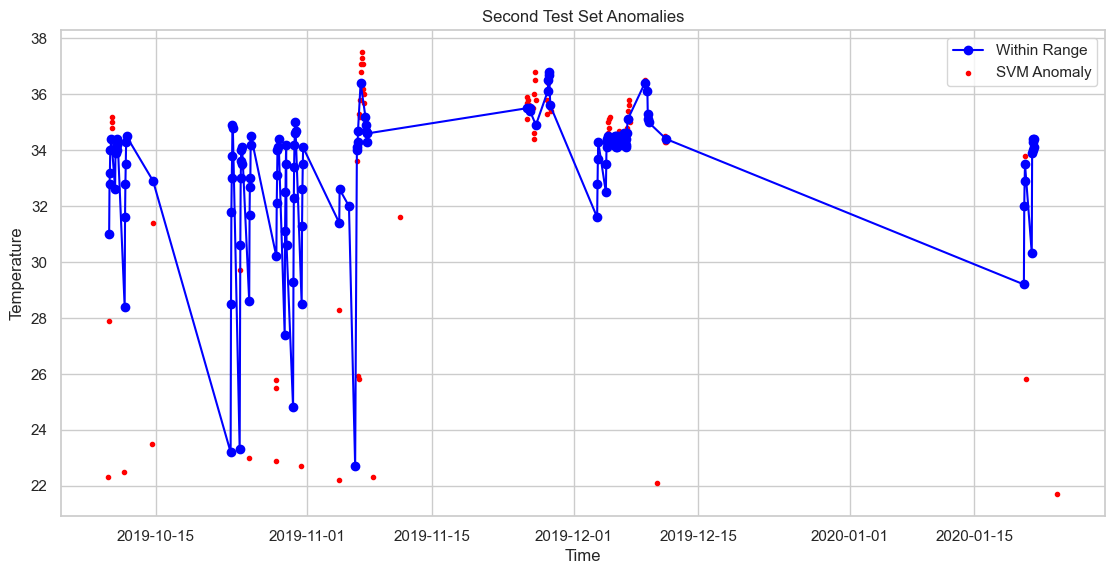

In [48]:
# Create anaomily plits
def plot_with_anomalies(test_data, title):

    normal_data = test_data[test_data['svm_pred'] == 1]

    forest = test_data[test_data['svm_pred'] == -1]

    plt.figure(figsize=(12, 6))
    plt.plot(normal_data.index, normal_data['heating_temperature'], label='Within Range', color='blue', marker='o', linestyle='-')
    plt.scatter(forest.index, forest['heating_temperature'], color='red', label='SVM Anomaly', marker='.')

    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Plot first test set
plot_with_anomalies(first_test_datetime.set_index('datetime'), 'First Test Set Anomalies')

# Plot second test set
plot_with_anomalies(second_test_datetime.set_index('datetime'), 'Second Test Set Anomalies')

# Summary

* As we could see, the data has a lot of gaps and its diffcult to really asses the cooling temp
* On the other hand we could not observe any seasonality or non stationarity, which makes it easier to model the timeseries
* The naive model already performs quite well, while the unsupervised random forest struggles a bit with the timeseries aspect and overvalues lower temps. SVM on the other hand captures the high temps well, but overestimates outliers
* In order to capture anomilies better either a supervised approach might be suitable or a very strict time series modeling with arima, ets or other model classes.


# What to do next, ideas projects

* More features are always nice, we could genereate rolling features maybe and cyylcing features aswell
* Bootstrapping and testing different models
* Testing diffrent models can be supported by labeled training data, maybe the stakeholders or producers of each machine have treshholds as what coutns as an anomaly
* Get weather data for the specific region, weather data for training and forecasts for predicting can be helpful to accuratly foreacst demand and therefore usage of the heating devices.
* More devices to look up how different devices beahve and if the model is robust among many devices.
